# Importing Packages Needed

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [0]:
import numpy as np

In [0]:
import scipy as sp

In [0]:
import matplotlib.pyplot as py

In [0]:
from scipy.optimize import curve_fit

In [0]:
from scipy.signal import find_peaks

In [0]:
import collections as col

# Definition of Named Tuples

In [0]:
component = col.namedtuple('component','phase intensity')

In [0]:
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2')

In [0]:
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [0]:
def gauss(x,cen,sd,amp):
    return amp*np.exp(-(x-cen)**2/2/sd**2)

def threegauss(x,cen1,sd1,amp1,cen2,sd2,amp2,cen3,sd3,amp3):
    return gauss(x,cen1,sd1,amp1)+gauss(x,cen2,sd2,amp2)+gauss(x,cen3,sd3,amp3)

In [0]:
def fitting_parameters(x,y,expected):
  params,cov=curve_fit(threegauss,x,y,expected)
  sigma=np.sqrt(np.diag(cov))
  return params, sigma

def gauss_fit(x,params):
  return threegauss(x,*params)

Finding Peak of Fittings Function

In [0]:
def gauss_peaks(fit, nofreqband, freqband):
  status='starting'
  
  i=3
  peakpos = find_peaks(fit, prominence=i, distance=50, height=i)[0]

  while len(peakpos) !=2 and i>=1 and i<5:
    if len(peakpos) < 2:
      i=i-0.5
      peakpos = find_peaks(fit, prominence=i, distance=50, height=1)[0]

    elif len(peakpos) > 2:
      i=i+0.5
      peakpos = find_peaks(fit, prominence=i, distance=50, height=2)[0]
    
  #Can be used for error checking
  #else:
    #print('Loop done')
    #print(i)

  if len(peakpos) == 2:
    status='pending'

    if peakpos[0]>=300 and peakpos[0]<=535 and peakpos[1]>=650 and peakpos[1]<=800:
      status='complete'
    else:
      status='error'

  else:
    status='error'


  if status=='complete':
    component1 = component(phase=(360/1024)*peakpos[0], intensity=fit[peakpos[0]])
    component2 = component(phase=(360/1024)*peakpos[1], intensity=fit[peakpos[1]])
  
  elif status=='error':
    component1 = component(phase=0, intensity=0)
    component2 = component(phase=0, intensity=0)

  else:
    print("Error: Something not complete in peak finding")

  freq=(((500-300)/nofreqband)*(nofreqband-freqband))+300 

  profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2)

  #Can be used for error checking
  #if status != 'error':
    #plot_peaks(x,y,profile_comp)

  return profile_comp

Plotting Fittings Functions

In [0]:
def plot_fit(x,y,fit,params,sigma):
  py.plot(x, y, lw=0.5, label='data')
  py.plot(x,fit, color='red',lw=3,label='gaussian fit')
  py.xlabel('Phase Bin')
  py.ylabel('Intensity')
  py.legend()
  return

In [0]:
def plot_fill(x,y,params):
  params1 = params[0:3]
  params2 = params[3:6]
  params3 = params[6:9]
  gfit1 = gauss(x, *params1)
  gfit2 = gauss(x, *params2)
  gfit3 = gauss(x, *params3)


  py.plot(x, y, lw=0.5, label='data')
  py.plot(x,fit,color='red',lw=3,label='gaussian fit')
  py.xlabel('Phase Bin')
  py.ylabel('Intensity')
  py.legend()

  py.plot(x, gfit1, "g")
  py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
  py.plot(x, gfit2, "y")
  py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

  py.plot(x, gfit3, "b")
  py.fill_between(x, gfit3.min(), gfit3, facecolor="blue", alpha=0.5)

  return 

In [0]:
def plot_peaks(x,y,profile_comp):
  py.plot(x,y, lw=0.5)
  py.plot(x, fit, color='red', lw=3, label='gaussian fit')

  x=[profile_comp[i][0] for i in range(1,3)]
  y=[profile_comp[i][1] for i in range(1,3)]

  py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

  py.xlabel('Phase (deg)')
  py.ylabel('Intensity')
  py.legend()
  return

Functions for Fitting Separation Data

In [0]:
def powerlaw(x, A, alpha, smin):
  return (A * (x**(-alpha)) + smin)

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [0]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [0]:
averageprofiles = np.loadtxt(fname='J0820/J0820_s_f28_T_pazi.pdv', dtype=fulldatatype)

In [0]:
no_freq_bands = max(averageprofiles['frequency'])+1

# Gaussian Plotting of Individual Frequency Band - Used for error checking individual frequency bands

Choosing Frequency Band. Following Section is for error checking:

In [0]:
freqband = 8
f = averageprofiles['frequency'] == freqband

In [0]:
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]

Gaussian Plots

In [0]:
x = phase
y = intensity

In [0]:
len(y)

1024

In [0]:
#Taken from Peaks and Gaussian fittings of frequency band 73
expected=(501,30,8.02,655,80,4.07,741,20,11.29)

In [0]:
params,sigma = fitting_parameters(x,y,expected)
fit = gauss_fit(x, params)
profile_comp = gauss_peaks(fit,no_freq_bands,freqband)

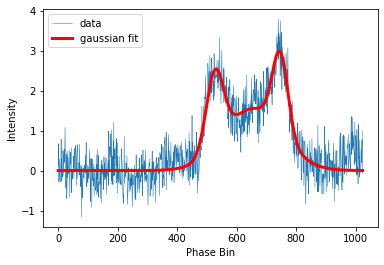

In [0]:
plot_fit(x,y,fit,params,sigma)

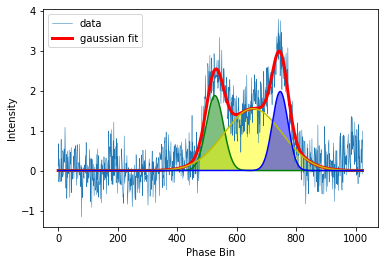

In [0]:
plot_fill(x,y,params)

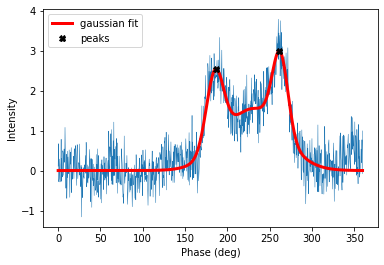

In [0]:
plot_peaks(x*(360/1024),y,profile_comp)

In [0]:
profile_comp

pulse_component(frequency=489.04109589041093, comp1=component(phase=186.6796875, intensity=2.542763302223699), comp2=component(phase=261.2109375, intensity=2.9904843747118854))

# Gaussian Plotting and Finding Peaks of Data

The following is a looped version of the previous section to find the correct peaks for each pulse profile

In [0]:
all_components = []

In [0]:
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
expected=(501,30,8.02,655,80,4.07,741,20,11.29)

for i in range(0,no_freq_bands):
  freqband = i
  
  #Can be used for error checking
  #print(freqband)

  f = averageprofiles['frequency'] == freqband

  x=averageprofiles['phase'][f]
  y=averageprofiles['intensity'][f]

  if len(x)!=0 and len(y)!=0:
    params,sigma = fitting_parameters(x,y,expected)
    fit = gauss_fit(x, params)
    profile_comp = gauss_peaks(fit, no_freq_bands, freqband)

    #Can be used for error checking
    #print(profile_comp)
  
    all_components.append(profile_comp)

# Movement of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

---



In [0]:
len(all_components)

123

In [0]:
phase_comp1=[]
frequency_comp1=[]

for i in range(0,len(all_components)):
  if all_components[i][1][0] != 0:
    phase_comp1.append(all_components[i][1][0])
    frequency_comp1.append(all_components[i][0])

Text(0, 0.5, 'Frequency')

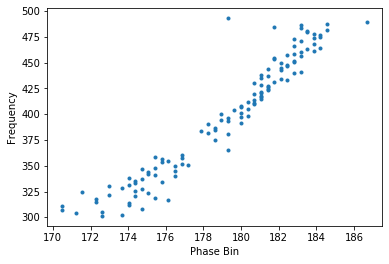

In [0]:
py.plot(phase_comp1,frequency_comp1, '.')
py.xlabel('Phase Bin')
py.ylabel('Frequency')

In [0]:
phase_comp2=[]
frequency_comp2=[]

for i in range(0,len(all_components)):
  if all_components[i][2][0] != 0:
    phase_comp2.append(all_components[i][2][0])
    frequency_comp2.append(all_components[i][0])

Text(0, 0.5, 'Frequency')

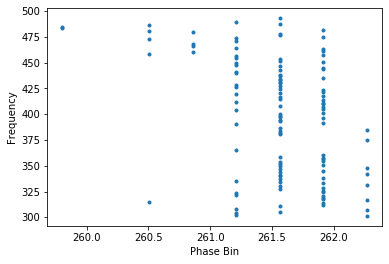

In [0]:
py.plot(phase_comp2,frequency_comp2, '.')
py.xlabel('Phase Bin')
py.ylabel('Frequency')

# Component Separation Across Frequency

In [0]:
def separation_singleprofile(components_array):
  sep_array=[]

  for i in range(0,len(components_array)):
    if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
    
      freq=components_array[i][0]
      sep=(components_array[i][2][0]) - (components_array[i][1][0])

      single_sep=component_separation(frequency=freq, separation=sep)

      sep_array.append(single_sep)

  return sep_array

In [0]:
component_sep = separation_singleprofile(all_components)

In [0]:
component_sep

[component_separation(frequency=493.1506849315068, separation=82.265625),
 component_separation(frequency=489.04109589041093, separation=74.53125),
 component_separation(frequency=487.67123287671234, separation=76.9921875),
 component_separation(frequency=486.3013698630137, separation=77.34375),
 component_separation(frequency=484.93150684931504, separation=78.046875),
 component_separation(frequency=483.56164383561645, separation=76.640625),
 component_separation(frequency=482.1917808219178, separation=77.34375),
 component_separation(frequency=480.82191780821915, separation=76.9921875),
 component_separation(frequency=479.45205479452056, separation=77.34375),
 component_separation(frequency=478.0821917808219, separation=77.6953125),
 component_separation(frequency=476.71232876712327, separation=77.34375),
 component_separation(frequency=475.3424657534247, separation=77.6953125),
 component_separation(frequency=473.972602739726, separation=77.34375),
 component_separation(frequency=47

In [0]:
comp_sep=[]
frequency_forsep=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep)):
  comp_sep.append(component_sep[i][1])
  frequency_forsep.append(component_sep[i][0])

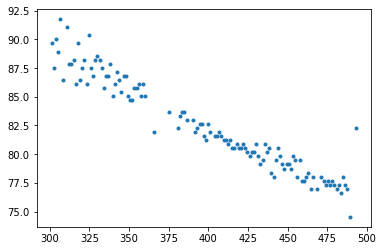

In [0]:
py.plot(frequency_forsep, comp_sep, '.')

# Attempted Fitting Power Laws to Separation

In [0]:
expect=(200,0.5,20)
sep_params,sep_cov=curve_fit(powerlaw,frequency_forsep,comp_sep, maxfev=1000000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


In [0]:
print(sep_params)
separation_fit = powerlaw(frequency_forsep, *sep_params)

[7.03227457e+02 3.96125675e-01 1.64735777e+01]


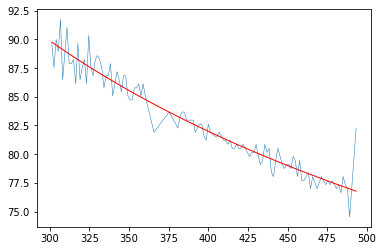

In [0]:
py.plot(frequency_forsep, comp_sep, lw=0.5, label='data')
py.plot(frequency_forsep,separation_fit, color='red',lw=1,label='power fit')

In [0]:
chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^-{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 703.227 ν^-0.396 + 16.474 

The chi squared value for the fit is:  1.5365339519492096
Units for Δθ is degrees and ν is MHz


# IGNORE - Attempted Fitting Power Laws to Phase

Below is attempts at fitting power laws. Ignore for now.

In [0]:
def powerlaw(x, A, alpha):
  return A * (x**alpha)

def powerlawint(x, A, alpha, c):
  return ((A*x**(alpha+1))/(alpha+1))+c

In [0]:
expect=[5.72993437e+15, -4.85937668]
params,cov=curve_fit(powerlaw,xaxis_comp1,yaxis_comp2, maxfev=10000)
#sigma=np.sqrt(np.diag(cov))

NameError: ignored

In [0]:
params

In [0]:
x=range(470,570)

In [0]:
py.plot(xaxis_comp1,yaxis_comp1, lw=0.5, label='data')
py.plot(x,powerlaw(x, *params), color='red',lw=1,label='power fit')

In [0]:
print(xaxis_comp1)
print(yaxis_comp1)
print(len(xaxis_comp1))
print(len(yaxis_comp1))

In [0]:
params,cov=curve_fit(powerlaw,xaxis_comp1_rev,yaxis_comp1_rev, maxfev=10000)
#sigma=np.sqrt(np.diag(cov))

In [0]:
params

In [0]:
x=range(290,560)

In [0]:
py.plot(xaxis_comp1_rev,yaxis_comp1_rev, lw=0.5, label='data')
py.plot(x,powerlaw(x, *params), color='red',lw=1,label='power fit')